## Классификатор пород кошек

### Классы:
- Мейн-кун;
- Сиамская;
- Британская короткошерстная;
- Сфинкс;
- Шотландская вислоухая;
- Персидская;
- Бенгальская;
- Русская голубая.

### Признаки:
- Сложность ухода (0 - простой, 1 - сложный);
- Гипоаллергенность (0 - не гипоаллергенная, 1 - гипоаллергенная);
- Спокойность характера (0 - не спокойная, 1 - спокойная);
- Отношение к детям (0 - не любит детей, 1 - любит детей);
- Разговорчивость (0 - редко подает голос, 1 - часто мяукает, разговаривает);
- Потребность во внимании (0 - требует мало внимания, 1 - постоянно нуждается в общении с хозяином);
- Отношение к другим животным (0 - сложно уживается, 1 - легко уживается).


### Задача прогнозирования:
Пользователь вводит свои предпочтения по признакам, из этих данных формируется **вектор** объекта. Вектор подается **обученной модели**, и на основе него (т.е. преподчтений пользователя) модель предоставляет **одну** или **несколько** пород кошек, наиболее удовлетворяющих его запросам.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from IPython.display import display, Math

### Описание класса данных о породах, класса модели и класса входных данных

In [2]:
@dataclass
class ClassData:
    index: int
    name: str
    vector: np.array

In [3]:
@dataclass
class FeatureData:
    index: int
    name: str
    desc: str

In [4]:
class PredictionData:
    def __init__(self, features: list[FeatureData]):
        self.vector = np.array([], dtype=int)
        self.features = features

    def input_data(self):
        def validate_input(input):
            try:
                if not (input == 1 or input == 0):
                    raise ValueError("Введено число отличное от 0 и 1")
                return input
            except (ValueError, TypeError):
                raise ValueError("Некорректное числовое значение")
        
        try:
            for feature in self.features:
                value = validate_input(int(input(f"{feature.name} ({feature.desc}):")))
                self.vector = np.append(self.vector, value)

        except ValueError as e:
            print(f"Ошибка: {e}")
    
    def print_data(self):
        print(f"Вектор объекта: {self.vector}")
        for feature in self.features:
            print(f"{feature.name}: {self.vector[feature.index]}")

In [5]:
class Model:
    def __init__(self, classes: list[ClassData]):
        self.classes = classes
        n = len(self.classes[0].vector)         # Количество признаков
        m = len(self.classes)                   # Количество классов
        self.matrix = np.zeros((n, m), dtype=int)
        self.error_history = []                 # История ошибок
        self.N = 1                              # Количество итераций
    
    def _detect_object(self, vector):
        names = []
        for cls in self.classes:
            names.append(cls.name)
        max_number = max(vector)
        idx_max = [i for i in range(len(vector)) if vector[i] == max_number]
        output = []

        if len(idx_max) == len(vector):
            output.append("None")
        elif len(idx_max) == 1:
            output.append(names[idx_max[0]])
        else:
            output.extend([names[i] for i in range(len(names)) if i in idx_max])
                
        return output
    
    def train_model(self):
        train_class = self.classes[0]    # Первый класс для обучения
        while True:
            # Инициализация данных обучаемого класса
            index = train_class.index
            name = train_class.name
            vector = train_class.vector

            print(f"## Итерация №{self.N}:")
            print(f"### Режим обучения (классом {name})...\n")

            # Поощряем нужный столбец
            self.matrix[:, index] += vector

            # Наказываем другие столбцы
            punishment_columns = np.arange(self.matrix.shape[1]) != index
            self.matrix[:, punishment_columns] -= vector.reshape(-1, 1)
            
            print(f"Обученная матрица:\n{self.matrix}\n")
            
            print(f"### Режим экспертизы...")
            print(f"=======================================\n")
            next_class = None
            error = len(self.classes)
            for exp_class in self.classes:
                # Перемножаем вектор класса на обуч. матрицу
                result = exp_class.vector @ self.matrix
                # Получаем распознанные объекты
                detected_obj = self._detect_object(result)

                print(f"Класс {exp_class.name} ---> {result}, max = {max(result)}")
                # Определяем успешность распознавания объекта
                if [exp_class.name] == detected_obj:
                    status = "Успешное распознавание"
                    error -= 1
                elif exp_class.name in detected_obj:
                    status = "Неоднозначное распознавание"
                    if not next_class:
                        next_class = exp_class
                else:
                    status = "Ошибочное распознавание"
                    if not next_class:
                        next_class = exp_class

                print(f"Распознан(ы): {detected_obj} ---> {status}\n")
            
            print(f"Ошибок: {error}")
            print(f"=======================================\n")
            self.error_history.append(error)

            if not next_class:
                print(f"Обучение завершено.")
                break

            train_class = next_class
            self.N += 1

    def print_model_stats(self):
        print(f"Для обучения понадобилось: {self.N} итераций")
        print(f"Итоговая матрица:\n{self.matrix}")

        ## TODO:
        # Отображение уровней системы (с использованием LaTeX)        
        for i in range(self.matrix.shape[1]):
            latex_str = f"y_{{{i+1}}} = "
            for index, coef in enumerate(self.matrix[:, i]):
                if coef > 0:
                    latex_str += f"+{coef}x_{{{index+1}}}"
                elif coef < 0:
                    latex_str += f"{coef}x_{{{index+1}}}"
                else:
                    pass
            display(Math(latex_str))

        fig, ax = plt.subplots(figsize=(16, 6))
        ax.plot(np.arange(start=1, stop=self.N+1, step=1), self.error_history, color = 'r', marker='.')
        ax.set(xlabel="Номер итерации", ylabel="Кол-во ошибок экспертизы", title="График кривой обучения")
        ax.grid()
        plt.show()

    def predict(self, prediction_data: PredictionData):
        result = prediction_data.vector @ self.matrix
        detected_obj = self._detect_object(result)

        print(f"На основе вектора: {prediction_data.vector}")
        if len(detected_obj) == 1:
            out = "Предлагаемый объект"
        else:
            out = "Предлагаемые объекты" 
        print(f"{out}: {', '.join(detected_obj)}")

### Инициализация классов и признаков для обучения

In [6]:
breed_features = [
    FeatureData(0, "Сложность ухода", "0 - простой, 1 - сложный"),
    FeatureData(1, "Гипоаллергенность", "0 - не гипоаллергенная, 1 - гипоаллергенная"),
    FeatureData(2, "Спокойность характера", "0 - не спокойная, 1 - спокойная"),
    FeatureData(3, "Отношение к детям", "0 - не любит детей, 1 - любит детей"),
    FeatureData(4, "Разговорчивость", "0 - редко подает голос, 1 - часто мяукает, разговаривает"),
    FeatureData(5, "Потребность во внимании", "0 - требует мало внимания, 1 - нуждается во внимании"),
    FeatureData(6, "Отношение к другим животным", "0 - сложно уживается, 1 - легко уживается")
]

breed_classes = [
    ClassData(0, "maine_coon", np.array([1, 0, 1, 1, 0, 0, 1])),
    ClassData(1, "siamese", np.array([0, 0, 0, 1, 1, 1, 1])),
    ClassData(2, "british_shorthair", np.array([0, 0, 1, 0, 0, 0, 1])),
    ClassData(3, "sphynx", np.array([1, 1, 0, 1, 1, 1, 1])),
    ClassData(4, "scottish_fold", np.array([0, 0, 1, 1, 0, 0, 1])),
    ClassData(5, "persian", np.array([1, 0, 1, 0, 0, 0, 1])),
    ClassData(6, "bengal", np.array([0, 1, 0, 1, 1, 1, 0])),
    ClassData(7, "russian_blue", np.array([0, 1, 1, 0, 0, 0, 0]))
]

In [7]:
# breed_classes.append(
#     ClassData(8, "abyssinian", np.array([0, 1, 0, 1, 0, 1, 1]))
# )
# breed_classes.append(
#     ClassData(9, "oriental", np.array([0, 1, 0, 1, 1, 1, 1]))
# )

### Создание и обучение модели

In [8]:
cat_model = Model(breed_classes)
cat_model.train_model()

## Итерация №1:
### Режим обучения (классом maine_coon)...

Обученная матрица:
[[ 1 -1 -1 -1 -1 -1 -1 -1]
 [ 0  0  0  0  0  0  0  0]
 [ 1 -1 -1 -1 -1 -1 -1 -1]
 [ 1 -1 -1 -1 -1 -1 -1 -1]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 1 -1 -1 -1 -1 -1 -1 -1]]

### Режим экспертизы...

Класс maine_coon ---> [ 4 -4 -4 -4 -4 -4 -4 -4], max = 4
Распознан(ы): ['maine_coon'] ---> Успешное распознавание

Класс siamese ---> [ 2 -2 -2 -2 -2 -2 -2 -2], max = 2
Распознан(ы): ['maine_coon'] ---> Ошибочное распознавание

Класс british_shorthair ---> [ 2 -2 -2 -2 -2 -2 -2 -2], max = 2
Распознан(ы): ['maine_coon'] ---> Ошибочное распознавание

Класс sphynx ---> [ 3 -3 -3 -3 -3 -3 -3 -3], max = 3
Распознан(ы): ['maine_coon'] ---> Ошибочное распознавание

Класс scottish_fold ---> [ 3 -3 -3 -3 -3 -3 -3 -3], max = 3
Распознан(ы): ['maine_coon'] ---> Ошибочное распознавание

Класс persian ---> [ 3 -3 -3 -3 -3 -3 -3 -3], max = 3
Распознан(ы): ['maine_coon'] ---> Ошибочное распознавание

Класс beng

Для обучения понадобилось: 35 итераций
Итоговая матрица:
[[ -4 -12 -12  -6 -12  -2 -12 -12]
 [-11 -11 -11  -5 -11 -11  -3  -3]
 [-16 -24 -12 -24 -14 -14 -24 -16]
 [-12 -12 -20 -14 -10 -20 -12 -20]
 [-11  -3 -11  -5 -11 -11  -3 -11]
 [-11  -3 -11  -5 -11 -11  -3 -11]
 [-19 -19 -15 -21 -17 -17 -27 -27]]


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

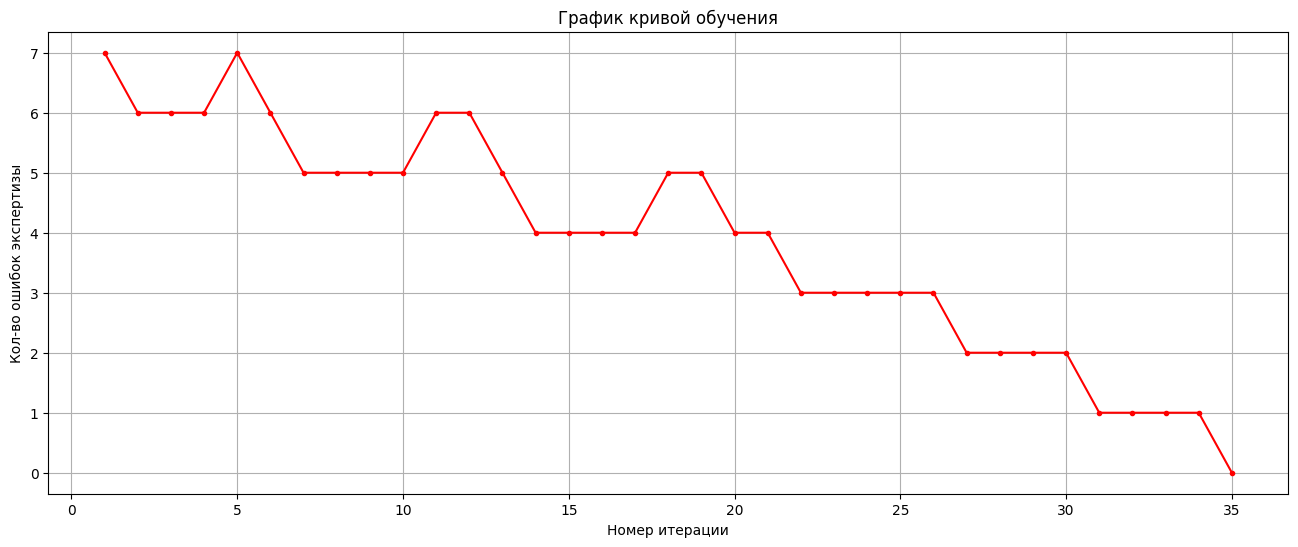

In [9]:
cat_model.print_model_stats()

### Ввод данных для прогнозирования

In [10]:
data = PredictionData(breed_features)
data.input_data()
data.print_data()

Вектор объекта: [1 1 1 1 0 0 0]
Сложность ухода: 1
Гипоаллергенность: 1
Спокойность характера: 1
Отношение к детям: 1
Разговорчивость: 0
Потребность во внимании: 0
Отношение к другим животным: 0


### Прогнозирование

In [11]:
cat_model.predict(data)

На основе вектора: [1 1 1 1 0 0 0]
Предлагаемый объект: maine_coon


In [12]:
import matplotlib.patches as patches
from matplotlib.colors import ListedColormap

In [13]:
def predict_with_weights(features, weights):
    """
    Предсказание класса на основе матрицы весов
    features: вектор признаков [x1, x2, ..., x7] (7 признаков)
    weights: матрица весов 7x8 (последний элемент - смещение)
    """
    # Добавляем единицу для смещения (bias)
    features_with_bias = np.append(features, 1)
    
    # Вычисляем оценки для каждого класса
    scores = weights @ features_with_bias
    
    # Возвращаем класс с максимальной оценкой
    return np.argmax(scores)

Для обучения понадобилось: 35 итераций
Итоговая матрица:
[[ -4 -12 -12  -6 -12  -2 -12 -12]
 [-11 -11 -11  -5 -11 -11  -3  -3]
 [-16 -24 -12 -24 -14 -14 -24 -16]
 [-12 -12 -20 -14 -10 -20 -12 -20]
 [-11  -3 -11  -5 -11 -11  -3 -11]
 [-11  -3 -11  -5 -11 -11  -3 -11]
 [-19 -19 -15 -21 -17 -17 -27 -27]]


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

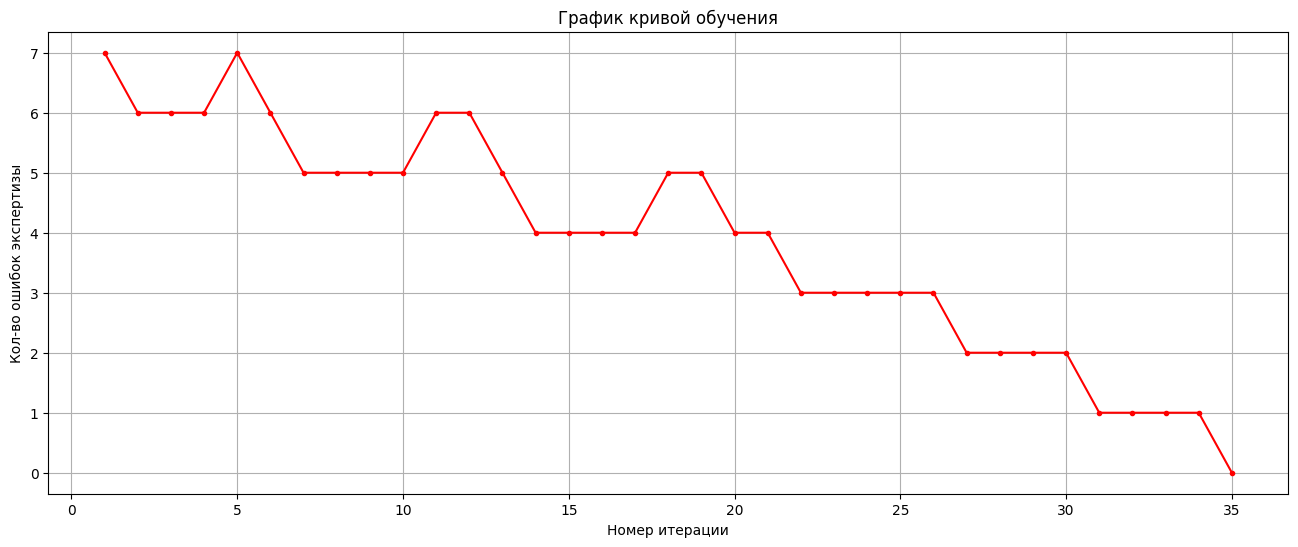

maine_coon: [1 0 1 1 0 0 1]
siamese: [0 0 0 1 1 1 1]
british_shorthair: [0 0 1 0 0 0 1]
sphynx: [1 1 0 1 1 1 1]
scottish_fold: [0 0 1 1 0 0 1]
persian: [1 0 1 0 0 0 1]
bengal: [0 1 0 1 1 1 0]
russian_blue: [0 1 1 0 0 0 0]


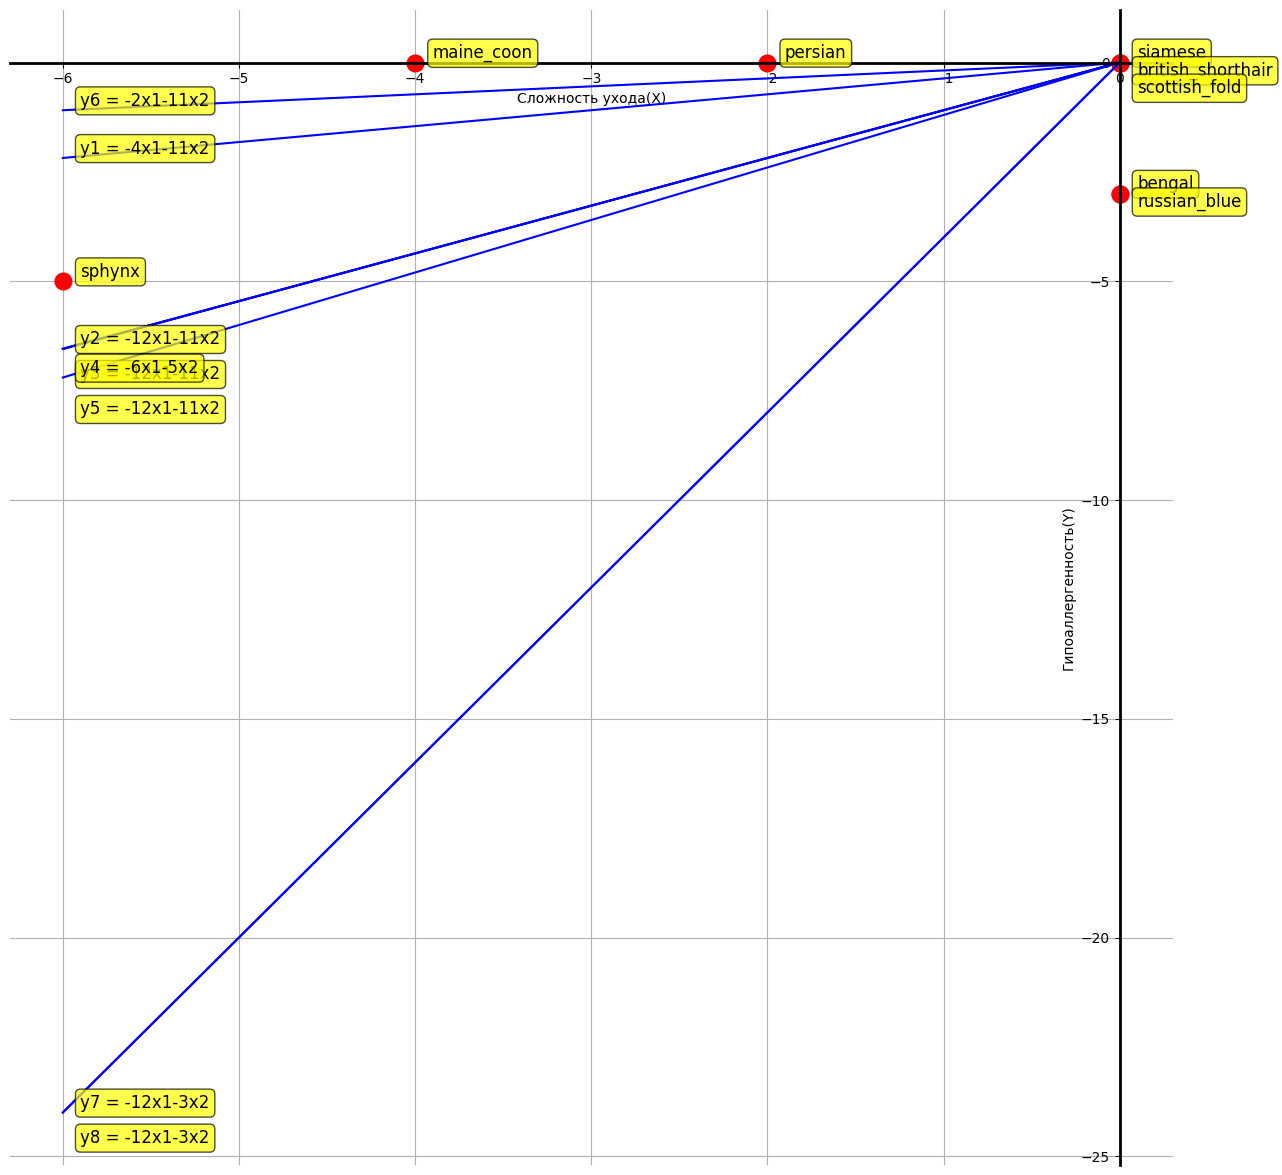

In [14]:
cat_model.print_model_stats()

marked_classes = []

plt.figure(figsize=(15,15))

ax = plt.gca()

ax.spines['left'].set_position('zero')
ax.spines['bottom'].set_position('zero')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_color('black')
ax.spines['bottom'].set_color('black')

for cls in breed_classes:
    print(f"{cls.name}: {cls.vector}")
    idx = cls.index
    xx = cat_model.matrix[0, idx] * breed_classes[idx].vector[0]
    yy = cat_model.matrix[1, idx] * breed_classes[idx].vector[1]

    shift = marked_classes.count((xx, yy)) * (-0.4)
    
    marked_classes.append((xx, yy))

    plt.plot(xx, yy, 'ro', markersize=12)
    plt.text(xx + 0.1, yy + 0.1 + shift, breed_classes[idx].name, fontsize=12, 
             bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7))
    
    x = np.linspace(-6, 0, 10)
    k = cat_model.matrix[0, idx] / cat_model.matrix[1, idx]
    y = x * k

    plt.plot(x, y, color='blue')
    plt.text(x[0] + 0.1, y[0] + 0.1 + shift * 2, f"y{cls.index + 1} = {cat_model.matrix[0, idx]}x1{cat_model.matrix[1, idx]}x2", fontsize=12, 
             bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7))


plt.xlabel(breed_features[0].name + '(X)')
plt.ylabel(breed_features[1].name + '(Y)')

plt.grid()
plt.show()